# Importing required libraries

In [10]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.algorithms.optimization_algorithm import OptimizationResult
from time import time
from getpass import getpass
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

# Setting up backends

## Setting up IBM Backends

In [11]:
#Uncomment this line only when you are running it for the first time 
#IBMQ.save_account(getpass("Token: ")) 

IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

ibmqfactory.load_account:WARNING:2022-02-26 02:55:12,994: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>]

In [12]:
provider = IBMQ.get_provider(hub='ibm-q-community',group='qhack-hackathon', project='7-qubit')
backend_sim = provider.get_backend('ibmq_qasm_simulator') #IBM QASM Simulator
backend_real = provider.get_backend('ibm_perth') #IBM Perth System

# Extracting our Data

In [13]:
#Extracting our data from CSV files of real stocks prices of 4 random companies
stocks_data = pd.DataFrame()
for file in glob.glob("./Stock Market Data/*.csv"):
    stock = pd.read_csv(file)
    if 'Date' not in stocks_data:
        stocks_data['Date'] = stock['Date'].astype('datetime64') 
    stocks_data[stock['Symbol'][0]] = stock['Close'] #Considering closing amount to be the price 
    
stocks_data.head() #Display top 5 rows

,Date,BAJAUTOFIN,HDFC,ITC,TELCO
0,2000-01-03,50.75,293.50,708.50,216.75
1,2000-01-04,48.10,304.05,712.35,208.20
2,2000-01-05,44.60,292.80,726.20,213.25
3,2000-01-06,45.25,296.45,784.30,222.10
4,2000-01-07,42.90,286.55,847.05,239.90


In [14]:
days = 30 #Number of days before the last data to buy
next_data = stocks_data.tail(days) #Data after number of days to check the future of portfolio
prev_data = stocks_data.iloc[:-days , :] #Previous Data to analyize the stocks

In [15]:
prev_data.tail() #Performace of companies prior to 5 days of buying

,Date,BAJAUTOFIN,HDFC,ITC,TELCO
5200,2021-03-08,5320.65,2217.70,195.55,172.05
5201,2021-03-09,5415.05,2191.35,193.85,171.45
5202,2021-03-10,5545.05,2238.40,194.80,173.75
5203,2021-03-12,5557.85,2256.25,193.65,180.35
5204,2021-03-15,5439.05,2306.95,194.40,179.75


In [16]:
next_data.tail() #Performace of companies in last 5 days

,Date,BAJAUTOFIN,HDFC,ITC,TELCO
5230,2021-04-26,4736.55,2661.35,202.80,196.75
5231,2021-04-27,4865.05,2657.50,201.50,198.15
5232,2021-04-28,5280.90,2751.20,202.50,220.65
5233,2021-04-29,5484.85,2747.55,206.45,237.80
5234,2021-04-30,5451.90,2670.90,211.25,242.60


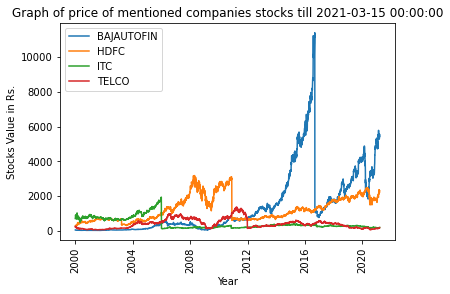

In [39]:
# Let's plot our finanical data

for companies in prev_data:
    if companies is not 'Date':
        plt.plot(prev_data['Date'],prev_data[companies], label=companies)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Stocks Value in Rs.')
plt.title(f"Graph of price of mentioned companies stocks till {prev_data['Date'].iloc[-1]}")
plt.savefig('share prices.png')
plt.show()

In [18]:
prev_data_wo_date = prev_data.loc[:, prev_data.columns != 'Date'] #Deleting Date column from previous data

prev_prices = prev_data_wo_date.tail(1).reset_index(drop=True) #Storing prices at the day they were bought

prices_now = next_data.loc[:,next_data.columns != 'Date'].tail(1).reset_index(drop=True) #Current prices

# Defining useful functions

In [19]:
def value_comparision(value_then: pd.DataFrame,
                      value_now: pd.DataFrame
                     )->None:
    '''
    Compares the values of stocks at the time of buying vs value of stocks now.
    
    Args:
        value_then: Value of stocks at the time of buying
        value_now: Value of stocks now
    '''
    profit = 0
    for col in value_then:
        diff = round(float(value_now[col]-value_then[col]),2)
        profit += diff
        perc = round(float(diff/value_then[col]*100),2)
        print(f"{str(col)}\n{diff}({perc}%)",end="")
        if diff > 0:
            print("↑")
        elif diff==0:
            print("-")
        else:
            print("↓")
            
    profit = round(profit,2)
    if profit > 0:
        print(f"\nYou gained a net profit of Rs.{profit}")
    elif profit==0:
        print("You neither gained any profit nor loss")
    else:
        print(f"\nYou incurred a net loss of Rs.{-profit}")

In [37]:
def analysis(result:OptimizationResult)->None:
    '''
    Presents the analysis of the result.
    
    Args:
        result: Optimization Result of VQE 
    '''

    print(result)
    print(f"\nIt took {result.time_taken} seconds to optimize")
    stocks_count = np.array(result.x)
    print("\nValue of stocks(in Rs.) at the time of buying")
    value_then = prev_prices*stocks_count
    print(value_then.to_string(index=False))
    print(f"You spent total Rs.{np.round(value_then.sum().sum(),2)}")
    print("\nLatest value of stocks(in Rs.)")
    value_now = prices_now*stocks_count
    print(value_now.to_string(index=False))
    print(f"Your stocks now value a total of Rs.{np.round(value_now.sum().sum(),2)}\n")
    value_comparision(value_then,value_now)

In [21]:
def get_period_return(stocks: pd.DataFrame)->np.array:
    '''
    Returns the period return of the given stocks
    
    Args:
        stocks: The Dataframe containing previous value of stocks of individual companies
        
    Returns:
        The period return of different stocks.
    '''
    
    def divide(val_1, val_2):
        if val_2 == 0:
            if val_1 == 0:
                return 1
            return np.nan
        return val_1 / val_2
    
    f = np.vectorize(divide)
    period_returns = f(stocks[:,1:], stocks[:,:-1]) - 1
    return period_returns

# Formulating Quadratic Problem

### Expected Return μ
Expected return of a portfolio is the anticipated amount of returns that a portfolio may generate, making it the mean (average) of the portfolio's possible return distribution. 

In [46]:
num_assets = 4           # Number of stocks we want to buy
risk_factor = 0.5        # Risk factor of 0.5
budget = 6              # Number of stocks we want to buy
period_return = get_period_return(np.transpose(prev_data_wo_date.to_numpy()))
mu = np.mean(period_return,axis=1) # Returns an array containing the mean value of each asset's expected return.
print(mu)
mu2 = pd.DataFrame(columns = prev_data_wo_date.columns)
mu2.loc[len(mu2.index)] = mu
mu2

[0.00155306 0.00084072 0.00031728 0.00053247]


,BAJAUTOFIN,HDFC,ITC,TELCO
0,0.001553,0.000841,0.000317,0.000532


### Covariance Matrix Σ
Covariance Σ is a statistical measure of how two asset's mean returns vary with respect to each other and helps us understand the amount of risk involved from an investment portfolio's perspective to make an informed decision about buying or selling stocks.

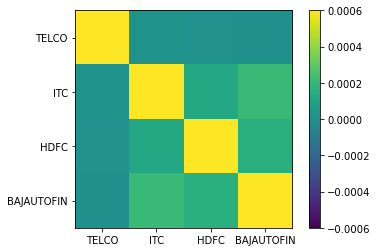

In [40]:
sigma = np.cov(period_return) #Returns the covariance matrix of the four assets

#Let's plot the covariance matrix of the period return
fig, ax = plt.subplots(1,1)
im = plt.imshow(sigma, extent=[-1,1,-1,1])
x_label_list = prev_data_wo_date.columns[::-1]
y_label_list = prev_data_wo_date.columns[::-1]
ax.set_xticks([-0.75,-0.25,0.25,0.75])
ax.set_yticks([0.75,0.25,-0.25,-0.75])
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
plt.colorbar()
plt.clim(-6.0e-04, 6.0e-04)
plt.savefig("sigma.png")
plt.show()

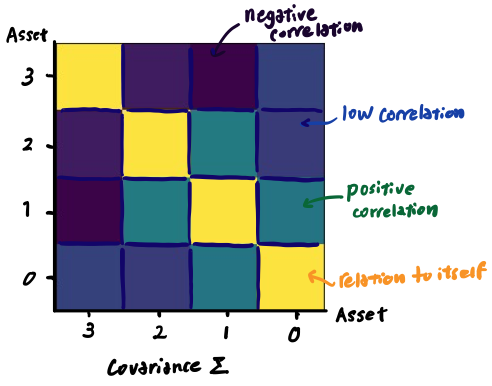
Source: Qiskit Fall 2021 Challenge

The left-to-right diagnoal values (yellow boxes in the figure below) show the relation of a stock with 'itself'. And the off-diagonal values show the deviation of each stock's mean expected return with respect to each other. 

In [24]:
bounds = [(0,budget//2) for i in range(num_assets) ]
qp = PortfolioOptimization(mu, sigma, risk_factor,
                           budget, bounds).to_quadratic_program()
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.001553060696 x_0 - 0.000840716705 x_1 - 0.000317283236 x_2
      - 0.000532465845 x_3 + [ 0.000939768541 x_0^2 + 0.000026287024 x_0*x_1
      + 0.000016003558 x_0*x_2 + 0.000002630525 x_0*x_3 + 0.000685025443 x_1^2
      + 0.000248013811 x_1*x_2 + 0.000414259249 x_1*x_3 + 0.000613056611 x_2^2
      + 0.000325935287 x_2*x_3 + 0.000938512248 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 6

Bounds
       x_0 <= 3
       x_1 <= 3
       x_2 <= 3
       x_3 <= 3

Generals
 x_0 x_1 x_2 x_3
End



## Solving the problem classically using NumPyMinimumEigensolver for reference

In [25]:
start = time()

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result_classical = exact_eigensolver.solve(qp)
result_classical.time_taken = time()-start

In [26]:
analysis(result_classical)

optimal function value: -0.0007154826499364188
optimal value: [2. 2. 1. 1.]
status: SUCCESS

It took 0.20679068565368652 seconds to optimize

Value of stocks(in Rs.) at the time of buying
 BAJAUTOFIN    HDFC    ITC   TELCO
    10878.1  4613.9  194.4  179.75
You spent total Rs.15866.15

Latest value of stocks(in Rs.)
 BAJAUTOFIN    HDFC     ITC  TELCO
    10903.8  5341.8  211.25  242.6
Your stocks now value a total of Rs.16699.45

BAJAUTOFIN
25.7(0.24%)↑
HDFC
727.9(15.78%)↑
ITC
16.85(8.67%)↑
TELCO
62.85(34.97%)↑

You gained a net profit of Rs.833.3


## Solving the problem using VQE in Qiskit

In [27]:
cobyla = COBYLA()
cobyla.set_options(maxiter=50)
circuit = TwoLocal(num_assets, 'ry', 'cz', reps=2, entanglement='sca') #Ansatz for the VQE

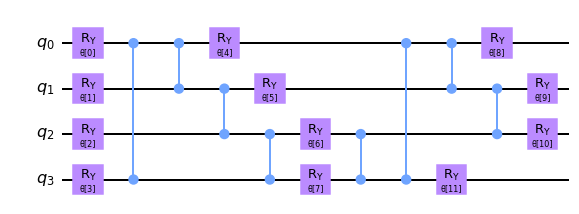

In [28]:
circuit.decompose().draw("mpl") #Displaying the Ansatz circuit

In [29]:
qubo = QuadraticProgramToQubo().convert(qp) #Converting the Quadratic Problem to QUBO Problem
operator, offset = qubo.to_ising() #Converting the QUBO Problem to Ising Hamiltonian
print(operator)
print(offset)

-0.0014324213224949922 * ZIIIIIII
- 0.0007162106612474961 * IZIIIIII
+ 1.0291425509051495 * ZZIIIIII
- 0.0010447661729795499 * IIZIIIII
+ 2.0575095572057833 * ZIZIIIII
+ 1.0287547786028917 * IZZIIIII
- 0.0005223830864891088 * IIIZIIII
+ 1.0287547786028917 * ZIIZIIII
+ 0.5143773893014458 * IZIZIIII
+ 1.028979823086664 * IIZZIIII
- 0.0007032415227379296 * IIIIZIII
+ 2.0575537191869544 * ZIIIZIII
+ 1.0287768595934772 * IZIIZIII
+ 2.057470596467865 * IIZIZIII
+ 1.0287352982339324 * IIIZZIII
- 0.0003516207613689648 * IIIIIZII
+ 1.0287768595934772 * ZIIIIZII
+ 0.5143884297967386 * IZIIIZII
+ 1.0287352982339324 * IIZIIZII
+ 0.5143676491169662 * IIIZIZII
+ 1.0290158075027767 * IIIIZZII
+ 0.00010971705397411213 * IIIIIIZI
+ 2.0573479048248067 * ZIIIIIZI
+ 1.0286739524124033 * IZIIIIZI
+ 2.0573545913414986 * IIZIIIZI
+ 1.0286772956707493 * IIIZIIZI
+ 2.0573597330742035 * IIIIZIZI
+ 1.0286798665371018 * IIIIIZZI
+ 5.4858526987056067e-05 * IIIIIIIZ
+ 1.0286739524124033 * ZIIIIIIZ
+ 0.5143369762062

### Running the VQE over IBM QASM Simulator

In [30]:
quantum_instance = QuantumInstance(backend=backend_sim)
vqe_sim = VQE(circuit, optimizer=cobyla, quantum_instance=quantum_instance)

In [31]:
start = time()
vqe = MinimumEigenOptimizer(vqe_sim)
result_ibm_sim = vqe.solve(qp)
result_ibm_sim.time_taken = time()-start

In [38]:
analysis(result_ibm_sim)

optimal function value: -0.0007154826499364188
optimal value: [2. 2. 1. 1.]
status: SUCCESS

It took 2040.010134522 seconds to optimize

Value of stocks(in Rs.) at the time of buying
 BAJAUTOFIN    HDFC    ITC   TELCO
    10878.1  4613.9  194.4  179.75
You spent total Rs.15866.15

Latest value of stocks(in Rs.)
 BAJAUTOFIN    HDFC     ITC  TELCO
    10903.8  5341.8  211.25  242.6
Your stocks now value a total of Rs.16699.45

BAJAUTOFIN
25.7(0.24%)↑
HDFC
727.9(15.78%)↑
ITC
16.85(8.67%)↑
TELCO
62.85(34.97%)↑

You gained a net profit of Rs.833.3


### Running the problem over IBM Perth Quantum System

The Ising operator requires 8 qubits to fully run, but we only have access to 7 qubit IBM Perth System so we won't be able to run the VQE over actual IBM System.